In [6]:
#VG441 Facility Location Code
import numpy as np
import pandas as pd
from gurobipy import *
import math
import matplotlib.pyplot as plt

In [7]:
#demand data
demand=pd.read_csv('Demand.csv')
max_amount=pd.read_csv('max_amount.csv')

#location data
sm=pd.read_csv('Supermarket Location.csv') #supermarket
fa=pd.read_csv('Facilities Location.csv') #facility
num_sm=len(sm)
num_fa=len(fa)

#cost data
cost=pd.read_csv('cost.csv')
base_charge=pd.read_csv('Charge.csv')
charge=base_charge*100 #这个越低开的facility越多 eg 100->10

In [8]:
def distance(a,b):
    dx=a[0]-b[0]
    dy=a[1]-b[1]
    return math.sqrt(dx*dx+dy*dy)

\begin{array}{lll}
\operatorname{minimize} & \sum_{j=1}^{m} f_{j} x_{j}+\sum_{i=1}^{n} \sum_{j=1}^{m} c_{i j} y_{i j} \\
\text { subject to: } & \sum_{j=1}^{m} y_{i j}=d_{i} & \text { for } i=1, \cdots, n \\
& \sum_{i=1}^{n} y_{i j} \leq M_{j} x_{j} & \text { for } j=1, \cdots, m \\
& y_{i j} \leq d_{i} x_{j} & \text { for } i=1, \cdots, n ; j=1, \cdots, m \\
& y_{i j} \geq 0 & \text { for } i=1, \cdots, n ; j=1, \cdots, m \\
& x_{j} \in\{0,1\} & \text { for } j=1, \cdots, m
\end{array}

In [9]:
m=Model()

x={} # open this facility or not
y={} # goods/services shipped from facility j to customer i
d={} # distance measures

for j in range(num_fa):
    x[j]=m.addVar(vtype=GRB.BINARY,name="x%d" %j)
    
for i in range(num_sm):
    for j in range(num_fa):
        y[i,j]=m.addVar(lb=0,vtype=GRB.CONTINUOUS,name="%d,%d" % (i,j))
        d[i,j]=distance(sm.iloc[i],fa.iloc[j])
        
# Add constraints
for i in range(num_sm):
    m.addConstr(quicksum(y[i,j] for j in range(num_fa))==demand.iloc[i]['Demand'])
    
for j in range(num_fa):
    m.addConstr(quicksum(y[i,j]for i in range(num_sm))<= max_amount.iloc[j]["Max"]*x[j])
    
for i in range(num_sm):
    for j in range(num_fa):
        m.addConstr(y[i,j] <= demand.iloc[i]['Demand'] * x[j])

# Objective function
m.setObjective(quicksum(charge.iloc[j]['Charge']*x[j] + quicksum(d[i,j]*y[(i,j)] 
        for i in range(num_sm)) for j in range(num_fa)))

m.update()
m.optimize()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 1110 rows, 1010 columns and 4010 nonzeros
Model fingerprint: 0xa9fea19b
Variable types: 1000 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+03]
  Objective range  [2e+00, 8e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+01]
Presolve removed 4 rows and 0 columns
Presolve time: 0.01s
Presolved: 1106 rows, 1010 columns, 3606 nonzeros
Variable types: 1000 continuous, 10 integer (10 binary)

Root relaxation: objective 3.189653e+04, 142 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    31896.531181 31896.5312  0.00%     -    0s

Explored 0 nodes (142 simplex iterations) in 0.07 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 31896.5 

Optimal solution found (tolerance 1.0

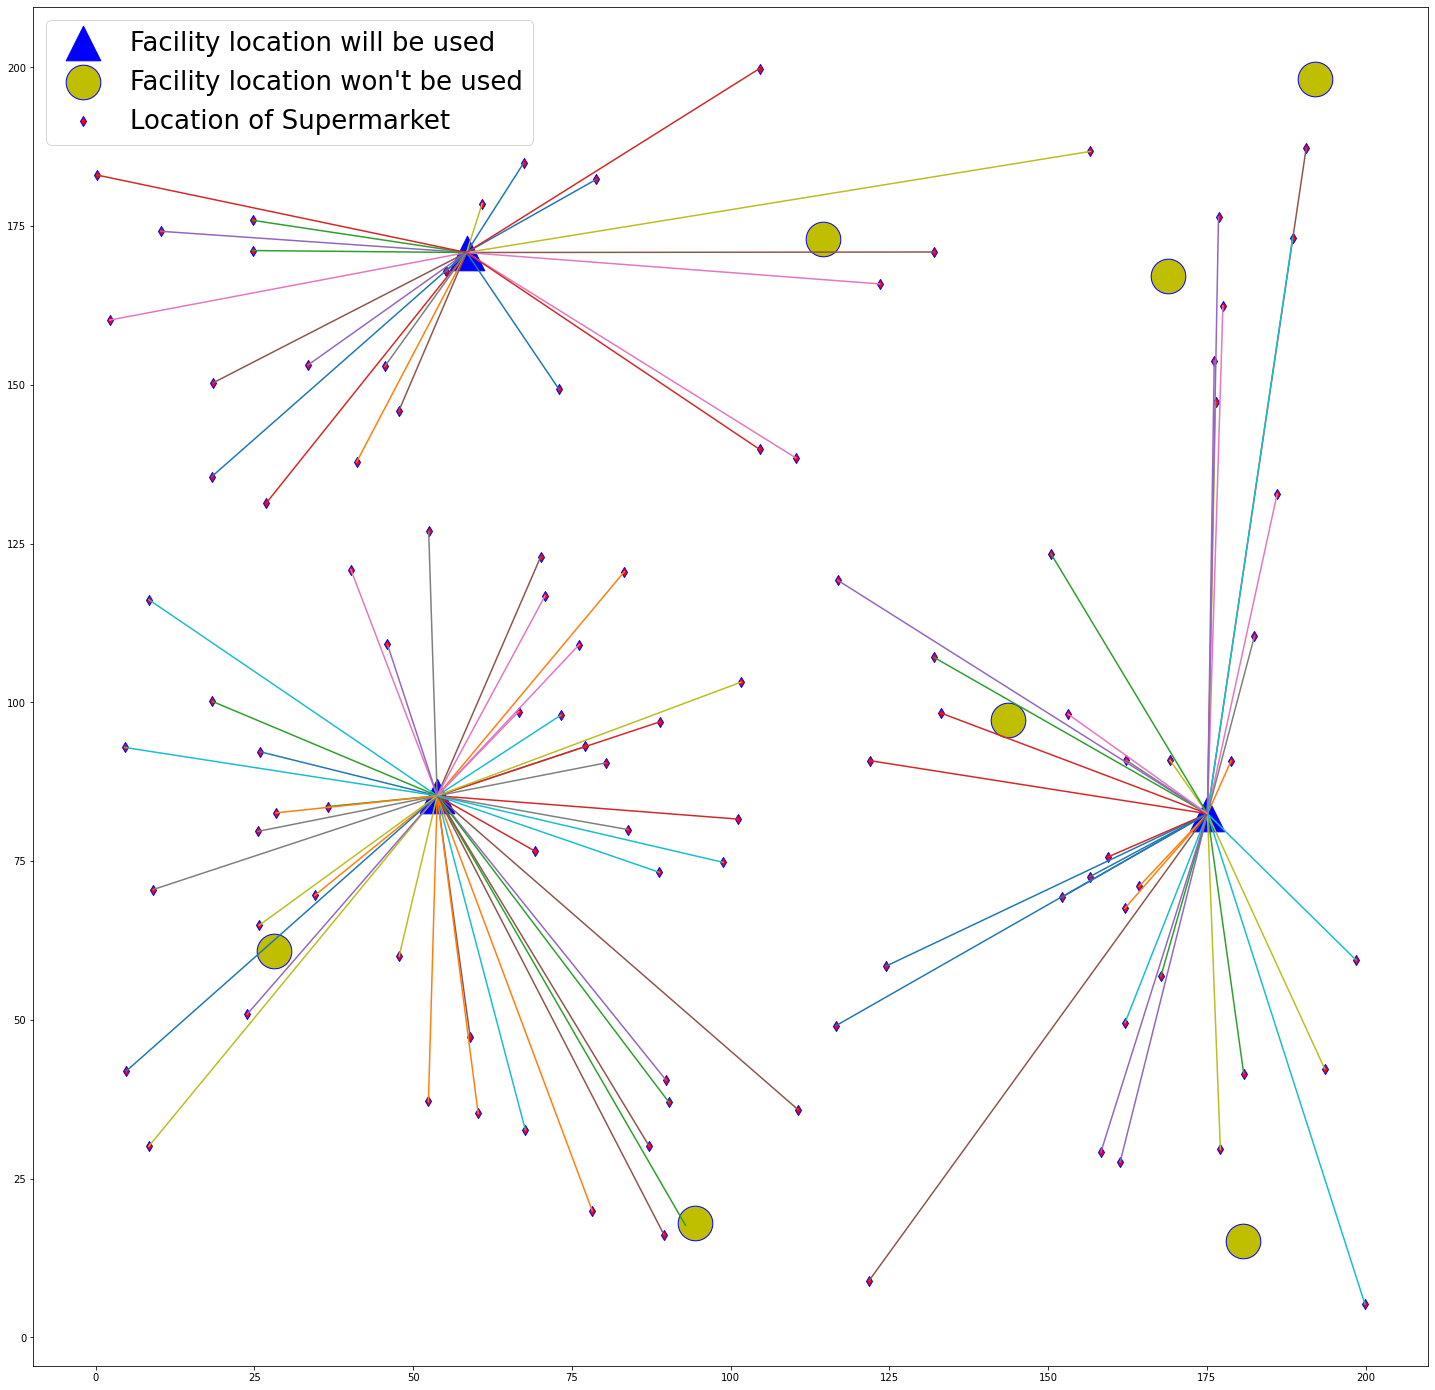

In [10]:
# Show supermarket location 
v_sm=sm["SM_V"]
h_sm=sm["SM_H"]
fig, ax1= plt.subplots(nrows=1, ncols=1,figsize=(25, 25))
e=ax1.scatter(x=h_sm, y=v_sm, marker='d', c='r', edgecolor='b', s=50)

# show facilities location
h_fa_use=[]
h_fa_no=[]
v_fa_use=[]
v_fa_no=[]
text=[]
for j in range(num_fa):
    if x[j].X==1:
        h_fa_use.append(fa.iloc[j]['FA_H'])
        v_fa_use.append(fa.iloc[j]["FA_V"])
    if x[j].X!=1:
        h_fa_no.append(fa.iloc[j]['FA_H'])
        v_fa_no.append(fa.iloc[j]["FA_V"])
a=ax1.scatter(x=h_fa_use, y=v_fa_use, marker='^', c='b', edgecolor='b', s=1200)
s=ax1.scatter(x=h_fa_no, y=v_fa_no, marker='o', c='y', edgecolor='b', s=1200)
ax1.legend([a,s,e],["Facility location will be used",
                    "Facility location won't be used",
                    "Location of Supermarket"],
            prop={'size': 26})

totx=0
for j in range(num_fa):
    if x[j].X == 1:
        totx= totx+1

variable_name=[]
for v in m.getVars():
    if v.X!= 0:
        variable_name.append('%s' % (v.varName))
variable_name=variable_name[totx:]

f=[]
for i in range(len(variable_name)):
    f.append(variable_name[i].split(","))
sm_location=[]
fa_location=[]
for i in range(len(f)):
    sm_location.append(int(f[i][0]))
    fa_location.append(int(f[i][1]))
h_fa_tot=[]
v_fa_tot=[]
for j in range(num_fa):
    h_fa_tot.append(fa.iloc[j]['FA_H'])
    v_fa_tot.append(fa.iloc[j]['FA_V'])
for i in range(len(sm_location)):
    ax1.plot([h_sm[sm_location[i]],h_fa_tot[fa_location[i]]],[v_sm[sm_location[i]],v_fa_tot[fa_location[i]]])